In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import emcee, corner
import starry

In [171]:
import astropy.units as u
from astropy.modeling.blackbody import blackbody_lambda

In [189]:
# Planet dayside effective temperature
teff = 2349 * u.K

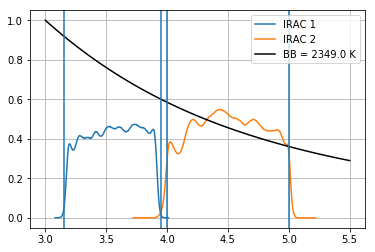

In [324]:
wl_irac1, tr_irac1 = np.loadtxt('filters/Spitzer_IRAC.I1.txt', unpack=True)
wl_irac2, tr_irac2 = np.loadtxt('filters/Spitzer_IRAC.I2.txt', unpack=True)

wl_irac1 /= 10000
wl_irac2 /= 10000

wl_irac1 = wl_irac1 * u.um
wl_irac2 = wl_irac2 * u.um

wl = np.linspace(3, 5.5, 100) * u.um
bb = blackbody_lambda(wl, teff) * wl

plt.plot(wl_irac1, tr_irac1, label='IRAC 1')
plt.plot(wl_irac2, tr_irac2, label='IRAC 2')
plt.plot(wl, bb/bb.max(), color='k', label='BB = {0}'.format(teff))
plt.legend()
plt.axvline(3.15)
plt.axvline(3.95)
plt.axvline(4.0)
plt.axvline(5.0)
plt.grid()
plt.show()

In [207]:
flux_irac2 = np.trapz(blackbody_lambda(wl_irac2, teff), wl_irac2)
flux_irac1 = np.trapz(blackbody_lambda(wl_irac1, teff), wl_irac1)
flux_ratio = flux_irac1 / flux_irac2

print(flux_ratio)

1.2190701426278001


Hot spot (lat, lon): (0.0, 41.56636963754948)
amp: 239.71547666956639
Hot spot (lat, lon): (0.0, 41.56636963754948)
amp: 196.63796879876293


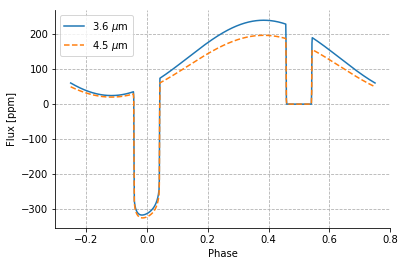

In [312]:
lmax = 1
lambda0 = 90
r = 0.0187
L_45 = 197e-6 * 1.1/2
L_36 = flux_ratio * L_45
inc = 83.3
a = 3.517
porb = 0.736539
prot = porb
tref = -porb / 2.

# Instantiate the star
star = starry.kepler.Primary()
star[1] = 0.0783
star[2] = 0.1407

# Instantiate the planet
planet = starry.kepler.Secondary(lmax=lmax)
planet.lambda0 = lambda0
planet.r = r
planet.L = L
planet.inc = inc
planet.a = a
planet.prot = prot
planet.porb = porb
planet.tref = tref

# Instantiate the system
system = starry.kepler.System(star, planet)

def set_coeffs(p, planet):
    """Set the coefficients of the planet map."""
    y1m1, y10, y11, L = p
    planet[1, :] = [y1m1, y10, y11]
    planet.L = L
    
def hotspot_offset(p):
    """Calculate the latitude and longitude of the hot spot in degrees"""
    x = p[2] / np.sqrt(np.sum(p[:3] ** 2))
    y = p[0] / np.sqrt(np.sum(p[:3] ** 2))
    z = p[1] / np.sqrt(np.sum(p[:3] ** 2))
    lat = np.degrees(np.arcsin(y))
    lon = np.degrees(np.arccos(z / np.sqrt(1 - y ** 2)))
    return lat, lon

norm = 1
p0 = 0
p1 = 0.53 
p2 = 1 - p1 

times = np.linspace(-3/4*porb, 1/4*porb, 1000)

for L, label, ls in zip([L_36, L_45], 
                        ["3.6 $\mu$m", "4.5 $\mu$m"],
                        ['-', '--']):
    c = np.array([p0, p1, p2, L])
    set_coeffs(c, planet)
    print("Hot spot (lat, lon):", hotspot_offset(c))
    system.compute(times)
    flux = system.lightcurve
    mid_eclipse_flux = flux[int(3/4*len(times))]
    flux = 1e6 * (flux - mid_eclipse_flux)
    print("amp:", flux.max())
    plt.plot(times / planet.porb + 0.5, flux, label=label, ls=ls)
plt.legend()
plt.xlabel('Phase')
plt.ylabel('Flux [ppm]')
for s in ['right', 'top']:
    plt.gca().spines[s].set_visible(False)
plt.grid(ls='--')
plt.savefig('plots/predicted_flux.pdf', bbox_inches='tight', dpi=300)
plt.show()

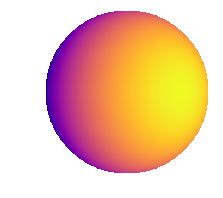

In [317]:
planet.show()